In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
import multiprocessing
from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import popln_overlap, get_fr

In [2]:
def get_site_distance(a, b):
    dist = min(
        abs(a - b), 16 - abs(a-b)
        ) % 16
    return dist

In [3]:
with open(pickle_dir / 'population_patterns.p', 'rb') as f: 
    population_patterns = pickle.load(f)

# Spatial Dimensionality

### Collect Distance Matrix

In [89]:
def get_distance_mat(fil_string):
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    distance_matrix = [[[] for _ in range(16)] for _ in range(16)]
    for i, noncr_visit in enumerate(noncr_visits):
        noncr_site = int(exp_data.visit_wedges[noncr_visit]) - 1
        if noncr_site == 16: continue
        navig_pattern_mat = visit_patterns[noncr_visit]
        for j, noncr2_visit in enumerate(noncr_visits):
            if j < i: continue
            noncr2_site = int(exp_data.visit_wedges[noncr2_visit]) - 1
            if noncr2_site == 16: continue
            navig2_pattern_mat = visit_patterns[noncr2_visit]
            overlaps = []
            for navig2_pattern in navig2_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(navig_pattern_mat, navig2_pattern)
                    ))
            max_overlap = np.nanmax(overlaps)
            distance_matrix[noncr_site][noncr2_site].append(max_overlap)
            if i != j:
                distance_matrix[noncr2_site][noncr_site].append(max_overlap)
    return np.array(distance_matrix)

In [ ]:
%%capture
PROCESSES = 5
distance_matrices = []
with multiprocessing.Pool(PROCESSES) as pool:
    params = [p for p in population_patterns.keys()]
    for res in pool.map(get_distance_mat, params):
        distance_matrices.append(res)

In [8]:
with open(pickle_dir / 'reactivation_place_dist_matrix.p', 'wb') as f:
    pickle.dump(distance_matrices, f)

### Plot raw distance matrices

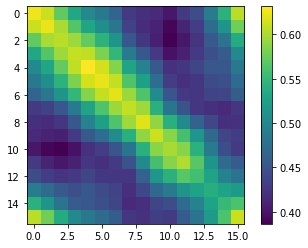

In [7]:
x = np.nanmean(distance_matrices, 0)
plt.imshow(x)
plt.colorbar()

In [ ]:
dist = np.arange(9)
vals = [[] for _ in range(9)]
for i in range(y.shape[0]):
    for j in range(y.shape[1]):
        y_ij = np.array(y[i,j])
        nonnan_vals = y_ij[np.logical_not(np.isnan(y_ij))].tolist()
        d = get_site_distance(i,j)
        vals[d].extend(nonnan_vals)
plt.plot(dist, [np.nanmedian(v) for v in vals])

### Visualize low-dim structure

# Cache v Cache Dimensionality

### Collect Distance Matrix

In [4]:
distance_matrix = [[[] for _ in range(16)] for _ in range(16)]
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, c_visit in enumerate(c_visits):
        c_site = int(exp_data.cr_sites[exp_data.cr_was_cache][i]) - 1
        cache_pattern_mat = visit_patterns[c_visit]
        for j, c2_visit in enumerate(c_visits):
            if j <= i: continue
            c2_site = int(exp_data.cr_sites[exp_data.cr_was_cache][j]) - 1
            cache2_pattern_mat = visit_patterns[c2_visit]
            overlaps = []
            for cache2_pattern in cache2_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(cache_pattern_mat, cache2_pattern)
                    ))
            max_overlap = np.nanmax(overlaps)
            distance_matrix[c_site][c2_site].append(max_overlap)
            if i != j:
                distance_matrix[c2_site][c_site].append(max_overlap)
distance_matrix = np.array(distance_matrix)

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: All-NaN slice encountered
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: All-NaN axis encountered
/home/chingf/Code/cache-arena-analysis/analysis/utils.py:56: RuntimeWarning: invalid value encountered in true_divide
  dist = adotb/(asumsq + bsumsq - adotb)


### Plot raw distance matrices

In [5]:
vals_by_sitedist = [[] for _ in range(9)]
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        mat_ij = np.array(distance_matrix[i,j])
        nonnan_vals = mat_ij[np.logical_not(np.isnan(mat_ij))].tolist()
        dist = get_site_distance(i,j)
        vals_by_sitedist[dist].extend(nonnan_vals)

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


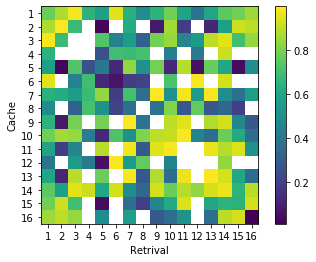

In [6]:
x = np.zeros(distance_matrix.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x[i,j] = np.nanmedian(distance_matrix[i,j])
plt.imshow(x)
plt.ylabel("Cache")
plt.xlabel("Retrival")
plt.xticks(np.arange(16), np.arange(16)+1)
plt.yticks(np.arange(16), np.arange(16)+1)
plt.colorbar()

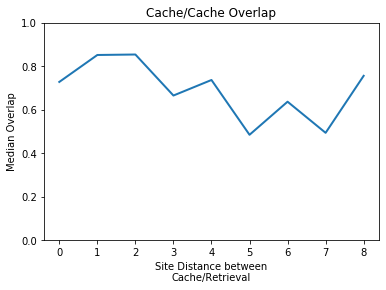

In [8]:
plt.plot(
    np.arange(9), [np.nanmedian(v) for v in vals_by_sitedist],
    linewidth=2
    )
plt.ylim(0, 1)
plt.title("Cache/Cache Overlap")
plt.xlabel("Site Distance between\nCache/Retrieval")
plt.ylabel("Median Overlap")
plt.show()

# Cache v Retrieval Dimensionality

### Collect Distance Matrix

In [23]:
distance_matrix = [[[] for _ in range(16)] for _ in range(16)]
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, c_visit in enumerate(c_visits):
        c_site = int(exp_data.cr_sites[exp_data.cr_was_cache][i]) - 1
        cache_pattern_mat = visit_patterns[c_visit]
        for j, r_visit in enumerate(r_visits):
            r_site = int(exp_data.cr_sites[exp_data.cr_was_retrieval][j]) - 1
#             if c_site == r_site:
#                 if r_visit < c_visit: continue
            retriev_pattern_mat = visit_patterns[r_visit]
            overlaps = []
            for retriev_pattern in retriev_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(cache_pattern_mat, retriev_pattern)
                    ))
            max_overlap = np.nanmax(overlaps)
            distance_matrix[c_site][r_site].append(max_overlap)
#             if c_site == r_site:
#                 break
distance_matrix = np.array(distance_matrix)

/home/chingf/Code/cache-arena-analysis/analysis/utils.py:56: RuntimeWarning: invalid value encountered in true_divide
  dist = adotb/(asumsq + bsumsq - adotb)
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: All-NaN slice encountered
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered


### Plot raw distance matrices

In [24]:
vals_by_sitedist = [[] for _ in range(9)]
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        mat_ij = np.array(distance_matrix[i,j])
        nonnan_vals = mat_ij[np.logical_not(np.isnan(mat_ij))].tolist()
        dist = get_site_distance(i,j)
        vals_by_sitedist[dist].extend(nonnan_vals)

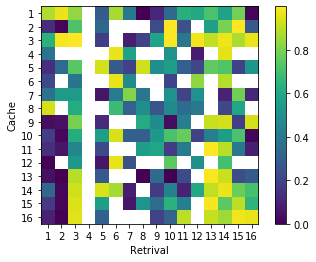

In [27]:
x = np.zeros(distance_matrix.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x[i,j] = np.nanmedian(distance_matrix[i,j])
plt.imshow(x)
plt.ylabel("Cache")
plt.xlabel("Retrival")
plt.xticks(np.arange(16), np.arange(16)+1)
plt.yticks(np.arange(16), np.arange(16)+1)
plt.colorbar()

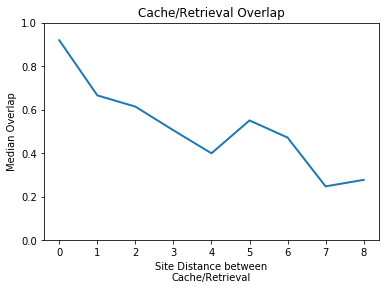

In [28]:
plt.plot(
    np.arange(9), [np.nanmedian(v) for v in vals_by_sitedist],
    linewidth=2
    )
plt.ylim(0, 1)
plt.title("Cache/Retrieval Overlap")
plt.xlabel("Site Distance between\nCache/Retrieval")
plt.ylabel("Median Overlap")
plt.show()

### Visualize low-dim structure

# Cache v Navigation Dimensionality

### Collect Distance Matrix

In [11]:
distance_matrix = [[[] for _ in range(16)] for _ in range(16)]
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    fr = population_patterns[fil_string]['fr']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, c_visit in enumerate(c_visits):
        c_site = exp_data.cr_sites[exp_data.cr_was_cache][i]
        c_site = int(c_site) - 1
        cache_pattern_mat = visit_patterns[c_visit]
        for j, noncr_visit in enumerate(noncr_visits):
            overlaps = []
            noncr_site = exp_data.visit_wedges[noncr_visit]
            noncr_site = int(noncr_site) - 1
            if noncr_site != c_site: continue
            navig_pattern_mat = visit_patterns[noncr_visit]
            for navig_pattern in navig_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(cache_pattern_mat, navig_pattern)
                    ))
            max_overlap = np.nanmax(overlaps)
            distance_matrix[c_site][noncr_site].append(max_overlap)
distance_matrix = np.array(distance_matrix)

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/chingf/Code/cache-arena-analysis/analysis/utils.py:56: RuntimeWarning: invalid value encountered in true_divide
  dist = adotb/(asumsq + bsumsq - adotb)
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: All-NaN axis encountered


### Plot raw distance matrices

In [12]:
vals_by_sitedist = [[] for _ in range(9)]
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        mat_ij = np.array(distance_matrix[i,j])
        nonnan_vals = mat_ij[np.logical_not(np.isnan(mat_ij))].tolist()
        dist = get_site_distance(i,j)
        vals_by_sitedist[dist].extend(nonnan_vals)

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


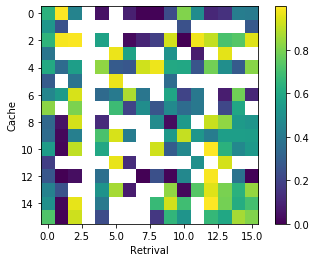

In [61]:
x = np.nanmean(distance_matrices, 0)
plt.imshow(x)
plt.ylabel("Cache")
plt.xlabel("Navigation")
plt.colorbar()

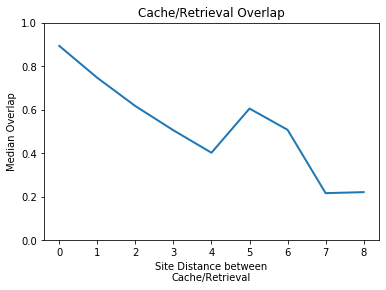

In [22]:
plt.plot(
    np.arange(9), [np.nanmedian(v) for v in vals_by_sitedist],
    linewidth=2
    )
plt.ylim(0, 1)
plt.title("Cache/Navigation Overlap")
plt.xlabel("Site Distance between\nCache/Retrieval")
plt.ylabel("Median Overlap")
plt.show()

### Visualize low-dim structure